# Setup: Import libraries and specify global variables

In [117]:
import requests
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In a production environment, the following key should be in a non-version controlled file

In [2]:
API_KEY='2OC9D1B9P0NOHN99'

# Data download and filtering

In [45]:
def get_data(symbol='BTC', market='CNY', output_path=None, start_date='1900-01-01', end_date='2100-01-01'):
    """
    Retrieves historical data for a given digital currency, trading market and date range.
    
    - A list of markets is available at https://www.alphavantage.co/physical_currency_list/
    - A list of currencies is available at https://www.alphavantage.co/digital_currency_list/
    - Start and end dates must be specified in ISO 8601 format ('YYYY-MM-DD').
    
    Returns a pandas.DataFrame with the relevant data. 
    If `output_path` is provided, said data is written to it as a CSV.
    """
    res = requests.get(
        url="https://www.alphavantage.co/query",
        params={
            'function': 'DIGITAL_CURRENCY_DAILY',
            'symbol': symbol,
            'market': market,
            'apikey': API_KEY
        })
    raw_df = pd.DataFrame.from_dict(jsondata["Time Series (Digital Currency Daily)"], orient='index')
    df = raw_df.ix[start_date:end_date]

    if output_path:
        df.to_csv(output_path, header=True, index=True, index_label='timestamp')
            
    return df

We'll use the above function to get all of the historicla data for BTC trading in the CNY market.

In [119]:
get_data(output_path='alphavantage.csv', symbol='BTC', market='CNY');

In [124]:
df = pd.read_csv("alphavantage.csv", index_col='timestamp')
# Alternatively, we could have avoided writing the file to disk and just done:
# df = get_data(symbol='BTC', market='CNY')

# (Simple) anomaly detection 

In [123]:
def find_anomalies(df, open_col="1b. open (USD)", close_col="4b. close (USD)", threshold=3):
    """
    Given a dataframe with colums for the opening (`open_col`) and closing (`close_col`) prices of an asset and a timestamp as index,
    this method returns the same dataset with three more columns:
    - open_close_diff: the differene between the closing and opening prices,
    - standard_score: the standard score associated with teh distribution of open_close_diff for each of its values
    - is_anomalous: True if the absolute value of the standard score for a given day is above the `threshold`
    """
    return_df = df.copy()
    return_df["open_close_diff"] = return_df[close_col] - return_df[open_col]
    return_df["standard_score"] = (return_df.open_close_diff - return_df.open_close_diff.mean()) / return_df.open_close_diff.std()
    return_df["is_anomalous"] = return_df.standard_score > threshold
    
    return return_df
    

In [130]:
df2 = find_anomalies(df)

In [129]:
df2[df2.is_anomalous][["1b. open (USD)", "4b. close (USD)", "open_close_diff", "standard_score"]]

,1b. open (USD),4b. close (USD),open_close_diff,standard_score
timestamp,,,,
2017-12-06,10444.800690,13481.503374,3036.702684,8.692704
2017-12-07,13481.503374,17274.365622,3792.862248,10.860198
2017-12-08,17274.365622,19214.732749,1940.367128,5.550112
2017-12-11,15832.240705,17296.730955,1464.490251,4.186035
2017-12-12,17296.730955,21794.628561,4497.897606,12.881146
2017-12-16,17318.091552,18741.236828,1423.145275,4.067522
2017-12-23,14014.023278,15081.287487,1067.264209,3.047406
2017-12-26,13578.687659,15638.652185,2059.964526,5.892932
2018-01-02,13512.425139,14729.885629,1217.460490,3.477937


The extraordinary movements detected by our simple script make a lot of sense: they match the heyday of the BTC bubble back in late 2017-early 2018.

# Open-Close plot and average

We are asked to create a script that "_reads the output file(s) from point ( 1 ) and plots the open and close prices for the last 30 days_". This can be done un several ways: for instance, one might wirte a script that only plots data from (1) if belongs to the last 30 days to date.

More reasonably, we can write a script that plots the last 30 days' worth of data from _any_ dataset, and then call it with a dataset that has information up until today/yesterday.

In [157]:
def plot_last_n_days(df, open_col="1b. open (USD)", close_col="4b. close (USD)", days=30, output_path=None):
    """
    Plots at most the last 30 days of data (or less if there are not enough) from a dataset having a date as index.
    Includes the average difference between closing and opening prices for those 30 days.
    The plot is saved in `output_path`.
    """
    plot_df = df.sort_index().tail(days)
    plot_df["open_close_diff"] = plot_df[close_col] - plot_df[open_col]
    
    plt.plot_date(plot_df.index.values, plot_df[open_col].values, 'g+', label="Open Price")
    plt.plot_date(plot_df.index.values, plot_df[close_col].values, 'rx', label="Close Price")
    
    plt.xticks(rotation=45)
    plt.legend()
    plt.title("""
    Open and Close price in USD dollars for BTC in the CNY market
    (Average daily close-open difference: {:.2f} USD)
    """.format(plot_df["open_close_diff"].mean()))

    fig = plt.gcf()
    
    if output_path:
        fig.set_size_inches(18.5, 10.5)
        fig.savefig(output_path, dpi=100)
    
    return fig

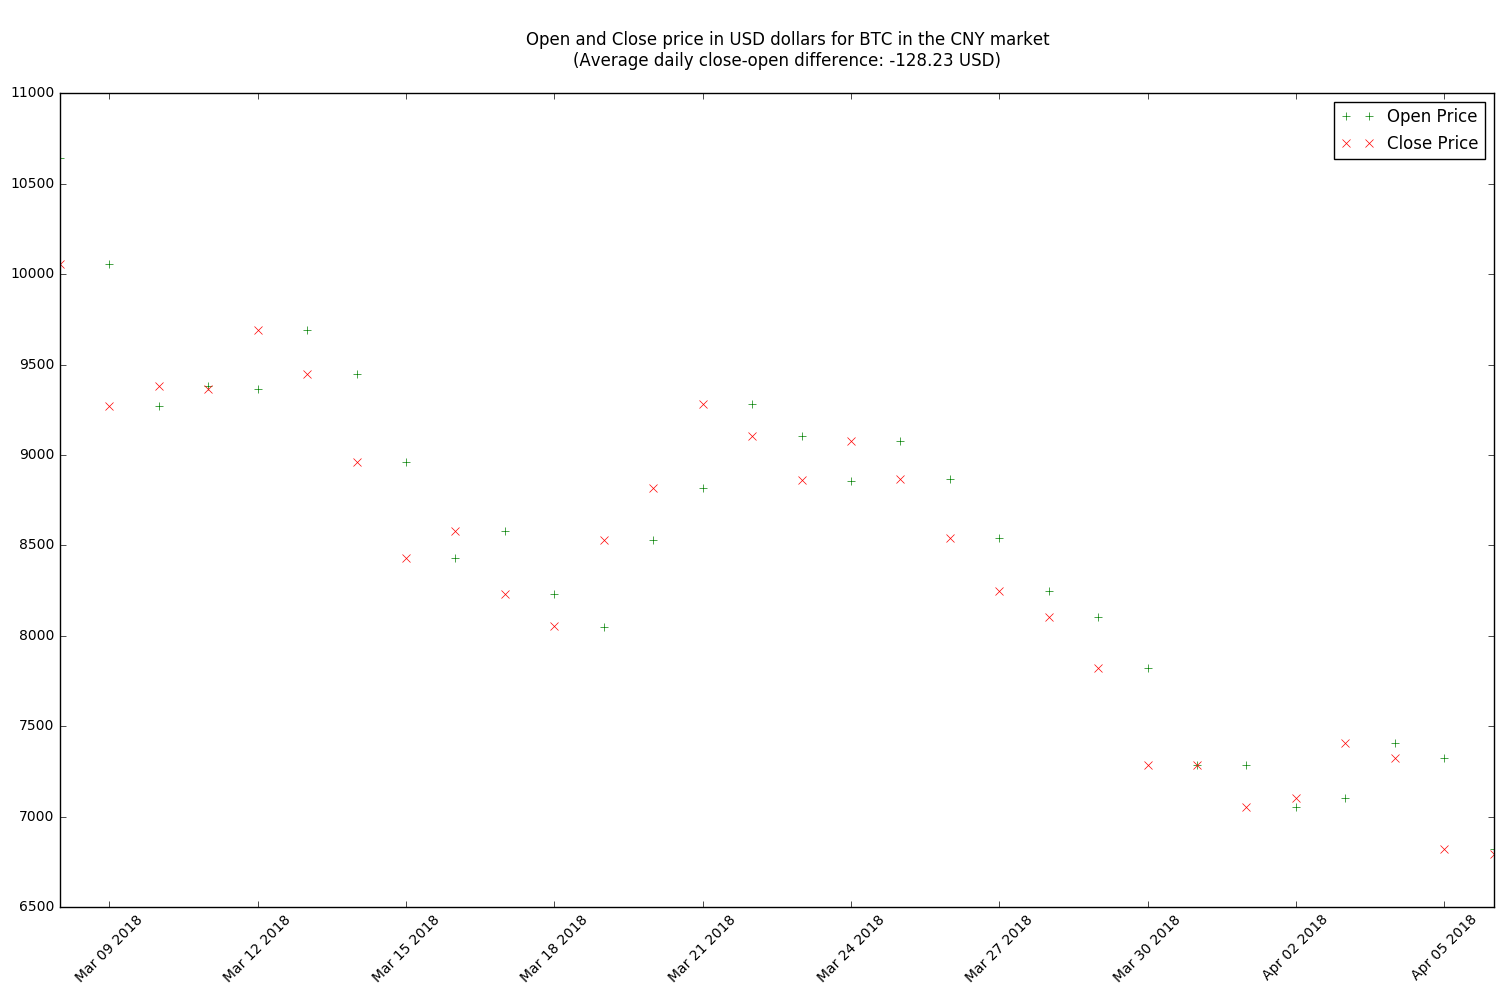

In [159]:
plot_last_n_days(df, output_path='BTC_open_close.png');